# Use Tensorflow to recognize English handwritten letters with EMINST dataset

## Xueyun
```
Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.
```

### Brief

In this notebook, we use the EMNIST data that is in mnist format
The main task is to classify handwritten letters into 26 different letters.
The major parts of the code:

- Extract training data, prepare input data for training model
- Convert jpg file to mnist format
- 5 layer neural network with L2 regularization, visulize the training using tensor board
- Restore the checkpoints to recoginze handwritten letters jpg files

In [1]:
# create data/fashion folder, if it doesn't exist
import os
import glob
from random import shuffle


In [2]:
# extract below dataset files stored in data/eminst_letter
# training images: train-images-idx3-ubyte.gz
# training labels: train-labels-idx1-ubyte.gz
# test images: t10k-images-idx3-ubyte.gz
# test labels: t10k-labels-idx1-ubyte.gz
from tensorflow.examples.tutorials.mnist import input_data

fash_data = input_data.read_data_sets('data/eminst_letter')


Extracting data/eminst_letter\train-images-idx3-ubyte.gz
Extracting data/eminst_letter\train-labels-idx1-ubyte.gz
Extracting data/eminst_letter\t10k-images-idx3-ubyte.gz
Extracting data/eminst_letter\t10k-labels-idx1-ubyte.gz


In [3]:
# Train and test images
X_train = fash_data.train.images
X_test = fash_data.test.images
#print(fash_data.test.labels)

# Train and test labels
y_train = fash_data.train.labels.astype("int")
y_test = fash_data.test.labels.astype("int")

#EMNIST letter dataset labels start from 1 to 26, 
#the label argument for tf.nn.sparse_softmax_cross_entropy_with_logits is [0, number of classes)
#so we need to decrease its labels value by 1 to adjust labels value to [0,26)
y_train = y_train -1
y_test = y_test - 1

In [4]:
# We use openCV to process image
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
from random import randint
import numpy as np
import cv2
import math
from scipy import ndimage
%matplotlib inline

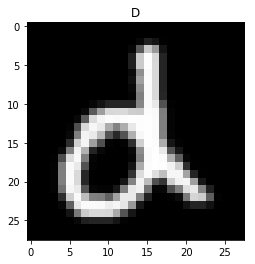

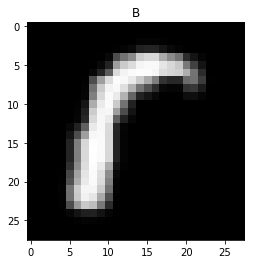

In [5]:
# print array format image
def gen_image(arr, im_title):
    image_data = (np.reshape(arr, (28, 28), order='F') * 255).astype(np.uint8)
   # print("gen_image")
   # print (image_data)
    plt.title(im_title)
    plt.imshow(image_data, interpolation='nearest', cmap='gray')
    return plt

#EMNIST letter dataset labels start from 1 to 26
fash_labels = {

    1:"A",
    2:"B",
    3:"C",
    4:"D",
    5:"E",
    6:"F",
    7:"G",
    8:"H",
    9:"I",
    10:"J",
    11:"K",
    12:"L",
    13:"M",
    14:"N",
    15:"O",
    16:"P",
    17:"Q",
    18:"R",
    19:"S",
    20:"T",
    21:"U",
    22:"V",
    23:"W",
    24:"X",
    25:"Y",
    26:"Z",
    
}

# Produces a new image for each run
im_index = randint(0, 100)
batch_X, batch_y = fash_data.train.next_batch(100)

#print("image: %d", batch_X[im_index])
#for im_index in range(100):
gen_image(batch_X[im_index], fash_labels[batch_y[im_index]]).show()

gen_image(fash_data.test.images[1070], fash_labels[fash_data.test.labels[1070]]).show()

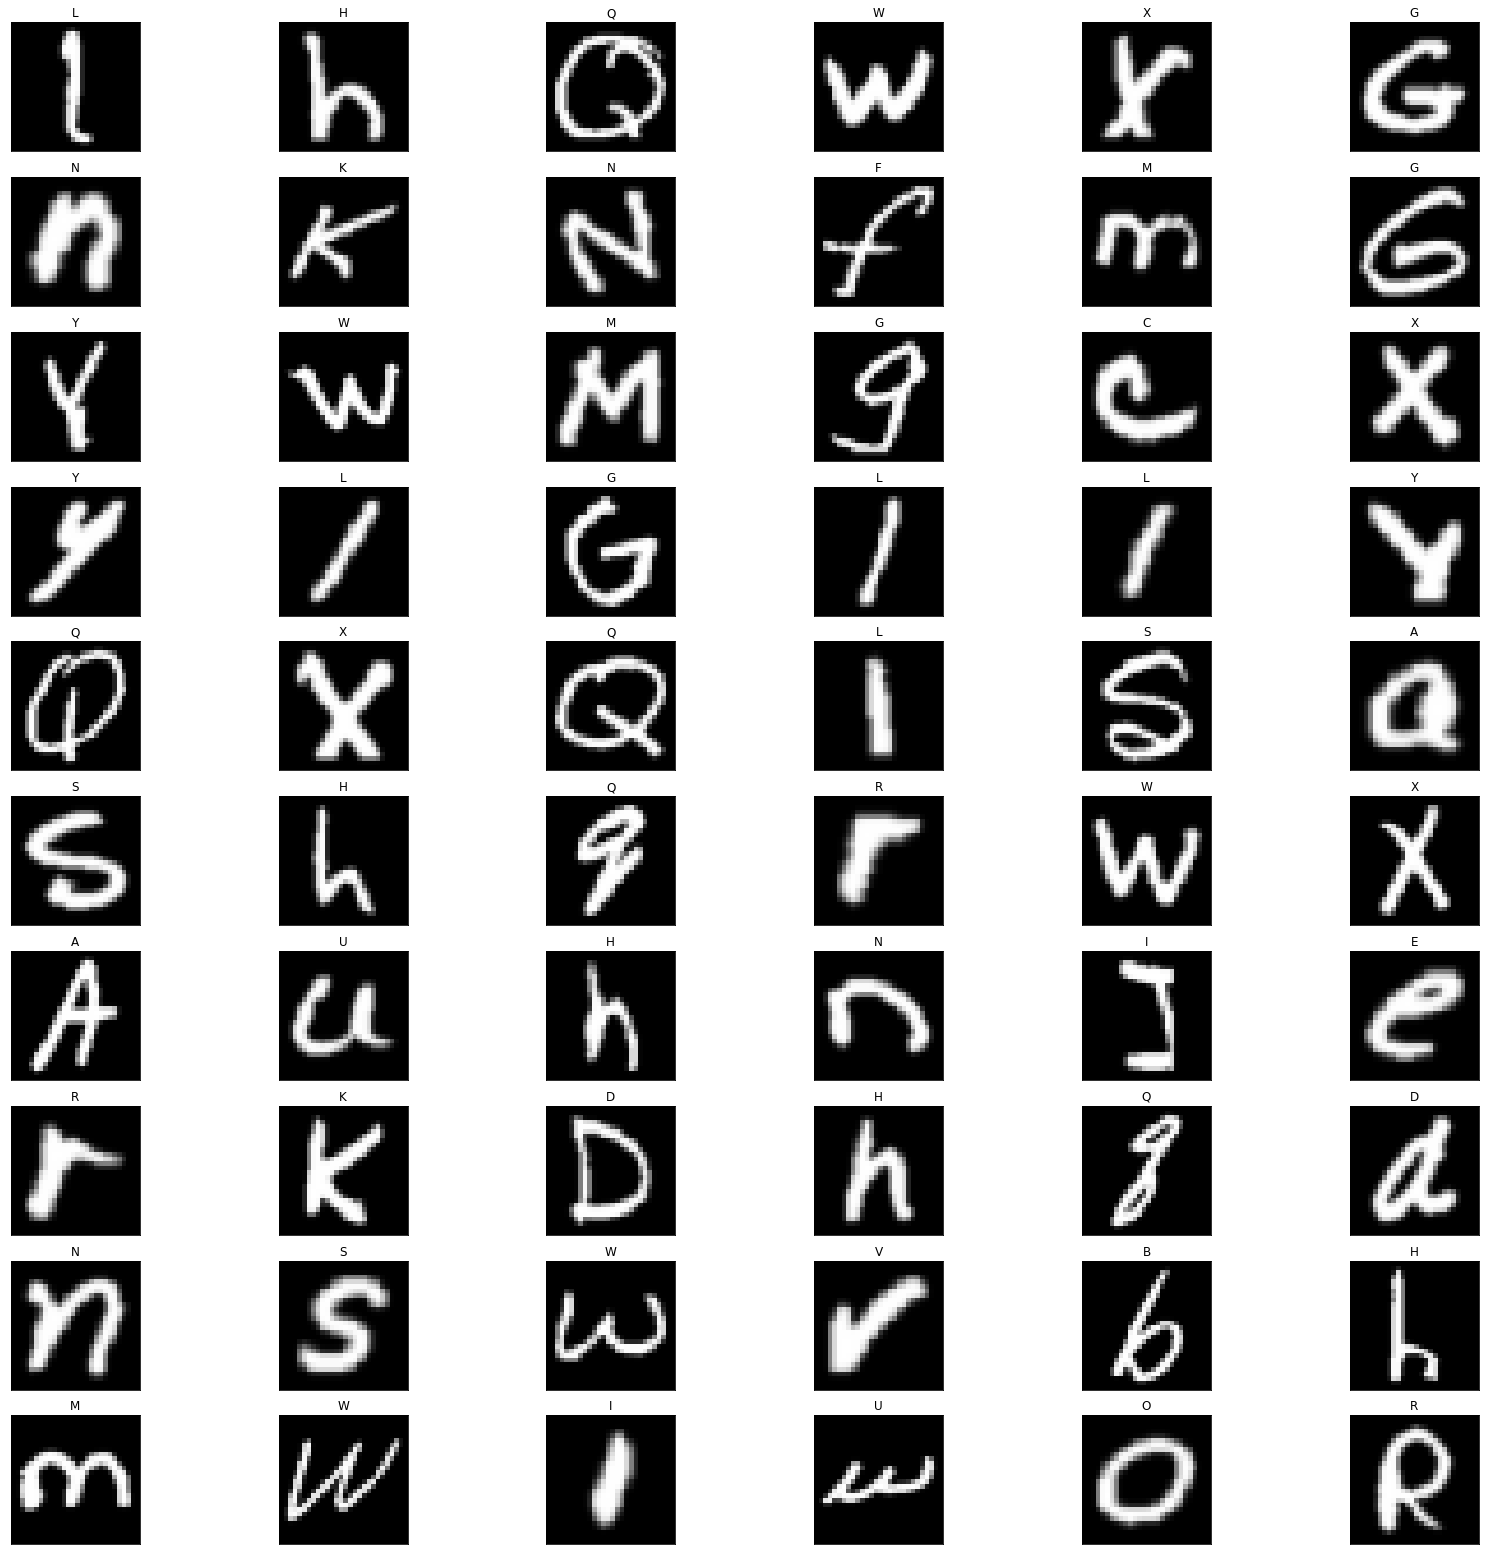

In [6]:
# Show a batch of training images in 6 columns grid

num_images = 60
batch_X, batch_y = fash_data.train.next_batch(num_images)
fig, axs = plt.subplots((num_images // 6), 6, figsize=(28,28))
axs = axs.ravel()
count = 0

for arr, label in zip(batch_X, batch_y):
    
    axs[count].set_title(fash_labels[label])
    image_data = (np.reshape(arr, (28, 28), order='F') * 255).astype(np.uint8)  
    plt.imshow(image_data, interpolation='nearest', cmap='gray')
    axs[count].imshow(image_data, interpolation='nearest', cmap='gray')
    axs[count].set_xticks([])
    axs[count].set_yticks([])
    count += 1 

### Convert jpg to MNIST format
- Open jpg file as gray image and convert it to image[28][28] array, in this array 255 is black and 0 is white
- convert image array to mnist format array
    - Gaussian Blur 
    - Make the gray image to black/white using OTSU threshold
    - reverse white and black
    - crop letter part by deleting backgroud pixels
    - padding letter part with 2 pixels backgroud
    - resize the padded image to 28x28 with CUBIC interpolation
  Then, we will get a letter in white and exactly in center of a 28x28 image with black background as MNIST format images



In [24]:
import tensorflow as tf
import numpy as np

num_inputs = 28*28  # letter MNIST
num_outputs = 26



In [25]:
#No need to use anymore
def getBestShift(img):
    cy,cx = ndimage.measurements.center_of_mass(img)
    
    rows,cols = img.shape
    shiftx = np.round(cols/2.0-cx).astype(int)
    shifty = np.round(rows/2.0-cy).astype(int)

    return shiftx,shifty

def shift(img,sx,sy):
    rows,cols = img.shape
    M = np.float32([[1,0,sx],[0,1,sy]])
    shifted = cv2.warpAffine(img,M,(cols,rows))
    return shifted

In [26]:
#convert jpg to MNIST format using OpenCV
def convertByCV(gray):
    
    gray = cv2.GaussianBlur(gray,(5,5),1)
    (thresh, gray) = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    #gray = cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,3,2)
    #(thresh, gray) = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY |cv2.THRESH_OTSU)
      
    gray = 255 - gray
    
    #print("origin{}".format(gray.shape))
    while np.sum(gray[0]) == 0:
        gray = gray[1:]
    while np.sum(gray[:,0]) == 0:
        gray = np.delete(gray,0,1)        
    while np.sum(gray[-1]) == 0:
        gray = gray[:-2]
    while np.sum(gray[:,-1]) == 0:
        gray = np.delete(gray,-1,1)
    

    print (gray.shape)
    rows,cols = gray.shape
    
    if rows>cols:
        colsPadding = (int(math.ceil((rows-cols)/2.0)+2),int(math.floor((rows-cols)/2.0)+2))
        rowsPadding = (2,2)
    else:
        rowsPadding = (int(math.ceil((cols-rows)/2.0)+2),int(math.floor((cols-rows)/2.0)+2))
        colsPadding = (2,2)
    gray = np.lib.pad(gray,(rowsPadding,colsPadding),'constant')
    print("squareGray{}".format(gray.shape))    
    
    interpolation = cv2.INTER_CUBIC

    gray = cv2.resize(gray, (28, 28),interpolation)

    print(gray.shape)
    return gray


### Define the network




In [27]:
summaries_dir = os.path.curdir + '/emnist'

if tf.gfile.Exists(summaries_dir):
    tf.gfile.DeleteRecursively(summaries_dir)
tf.gfile.MakeDirs(summaries_dir)

In [28]:
# Reset graph and set seed to produce reproducible results across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)
    
reset_graph()

X = tf.placeholder(tf.float32, shape=(None, num_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

In [29]:
# Define summary for tensor board
def variable_summaries(var):
  """Attach a lot of summaries to a Tensor (for TensorBoard visualization)."""
  with tf.name_scope('summaries'):
    mean = tf.reduce_mean(var)
    tf.summary.scalar('mean', mean)
    with tf.name_scope('stddev'):
      stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
    tf.summary.scalar('stddev', stddev)
    tf.summary.scalar('max', tf.reduce_max(var))
    tf.summary.scalar('min', tf.reduce_min(var))
    tf.summary.histogram('histogram', var)

In [30]:
def conv2d(x, W):
  """conv2d returns a 2d convolution layer with full stride."""
  return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')


def max_pool_2x2(x):
  """max_pool_2x2 downsamples a feature map by 2X."""
  return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')


def weight_variable(shape):
  """weight_variable generates a weight variable of a given shape."""
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial)


def bias_variable(shape):
  """bias_variable generates a bias variable of a given shape."""
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)



In [31]:
# Define a hidden layer method that creates a name scope in the TF graph
# weights are also returned for L2 regularization
def fc(X, num_neurons, name, activation=None):
    # Use a name scope to clearly separate the layers on TensorBoard
    with tf.name_scope(name):
        num_inputs = int(X.get_shape()[1])
        
        stddev = 2 / np.sqrt(num_inputs)
        # Initialize the weights with truncated normal and standard deviation from input data
        init = tf.truncated_normal((num_inputs, num_neurons), stddev=stddev)
        # Weights and bias
        W = tf.Variable(init, name="weights")
        
        b = tf.Variable(tf.zeros([num_neurons]), name="bias")
        # Output
        Z = tf.matmul(X, W) + b
        # Support for returning values with and without non-linearity
        if activation is not None:
            Z = activation(Z)
            
        return (Z, W)

In [32]:
def deepnn(x, num_class):
  """deepnn builds the graph for a deep net for classifying letters.

  Args:
    x: an input tensor with the dimensions (N_examples, 784), where 784 is the
    number of pixels in a standard EMNIST image.

  Returns:
    A tuple (y, keep_prob). y is a tensor of shape (N_examples, 26), with values
    equal to the logits of classifying the digit into one of 26 classes (the
    digits a-z). keep_prob is a scalar placeholder for the probability of
    dropout.
  """
  # Reshape to use within a convolutional neural net.
  # Last dimension is for "features" - there is only one here, since images are
  # grayscale -- it would be 3 for an RGB image, 4 for RGBA, etc.
  with tf.name_scope('reshape'):
    x_image = tf.reshape(x, [-1, 28, 28, 1])

  # First convolutional layer - maps one grayscale image to 32 feature maps.
  with tf.name_scope('conv1'):
    W_conv1 = weight_variable([5, 5, 1, 32])
    b_conv1 = bias_variable([32])
    h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)

  # Pooling layer - downsamples by 2X h_pool1.shape=(14,14,32).
  with tf.name_scope('pool1'):
    h_pool1 = max_pool_2x2(h_conv1)

  # Second convolutional layer -- maps 32 feature maps to 64.
  with tf.name_scope('conv2'):
    W_conv2 = weight_variable([5, 5, 32, 64])
    b_conv2 = bias_variable([64])
    h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)

  # Second pooling layer, downsamples by 2, h_pool2.shape = (7,7,64)
  with tf.name_scope('pool2'):
    h_pool2 = max_pool_2x2(h_conv2)

  # Fully connected layer 1 -- after 2 round of downsampling, our 28x28 image
  # is down to 7x7x64 feature maps -- maps this to 1024 features/neurons.
  with tf.name_scope('fc1'):
    
    #W_fc1 = weight_variable([7 * 7 * 64, 1024])
    #b_fc1 = bias_variable([1024])

    h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
    print(h_pool2_flat.shape)
    h_fc1, W_fc1 = fc(h_pool2_flat, num_neurons = 1024, name='fc1', activation=tf.nn.relu)
    #h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

  # Dropout - controls the complexity of the model, prevents co-adaptation of
  # features.
  with tf.name_scope('dropout'):
    keep_prob = tf.placeholder(tf.float32)
    h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

  # Map the 1024 features to 10 classes, one for each digit
  with tf.name_scope('fc2'):
    W_fc2 = weight_variable([1024, num_class])
    b_fc2 = bias_variable([num_class])

    y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2
  return y_conv, keep_prob


In [33]:

# When overfit, apply L2 regularization,  lambd value 

num_outputs = 26
lambd = 0.002
learning_rate = 0.017

y_conv, keep_prob = deepnn(X, num_class = num_outputs)
    
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=y_conv)
    loss = tf.reduce_mean(xentropy, name="loss")
    #l2_regular = lambd*tf.nn.l2_loss(layer_1_weights)+lambd*tf.nn.l2_loss(layer_2_weights) + lambd*tf.nn.l2_loss(layer_3_weights)+lambd*tf.nn.l2_loss(layer_4_weights) + lambd*tf.nn.l2_loss(logits_weights)+ lambd*tf.nn.l2_loss(layer_5_weights)
    #loss = tf.reduce_mean(xentropy, name="loss")+ l2_regular
tf.summary.scalar('loss', loss)
    

with tf.name_scope("train"):
    #optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
    #training_op = optimizer.minimize(loss)
    training_op = tf.train.AdamOptimizer(1e-4).minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(y_conv, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
tf.summary.scalar('accuracy', accuracy)



(?, 3136)


<tf.Tensor 'accuracy:0' shape=() dtype=string>

In [34]:
# Define the initialization and saver for saving our model to local file system
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [36]:
# Define the number of epochs and batch size 
num_epochs = 20
batch_size = 64
print("start to train")

with tf.Session() as sess:
    # Merge all the summaries and write them out to /tmp/mnist_logs (by default)
    
    merged = tf.summary.merge_all()
    train_writer = tf.summary.FileWriter(summaries_dir + '/train2',
                                      sess.graph)
    test_writer = tf.summary.FileWriter(summaries_dir + '/test')
    
    init.run()
    for epoch in range(num_epochs):
        # Train the network by feeding in batch_size examples for each iteration
        for iteration in range(fash_data.train.num_examples // batch_size):
            X_batch, y_batch = fash_data.train.next_batch(batch_size)
            
            #EMNIST letter dataset labels start from 1 to 26, 
            #the label argument for tf.nn.sparse_softmax_cross_entropy_with_logits is [0, number of classes)
            #so we need to decrease its labels by 1 to adjust labels value to [0,26)
            y_batch = y_batch -1
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch, keep_prob: 1.0})
           # summary, _ = sess.run([merged, training_op], feed_dict={X: X_batch, y: y_batch})
            
            #train_writer.add_summary(summary, iteration)
        
        # Evaluate test data after every epoch
        #acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        summary, acc_train =  sess.run([merged, accuracy], feed_dict={X: X_batch, y: y_batch, keep_prob: 1})
        train_writer.add_summary(summary, epoch)
        
        #acc_test = accuracy.eval(feed_dict={X: fash_data.test.images, y: y_test})
        summary, acc_test = sess.run([merged, accuracy],feed_dict={X: fash_data.test.images, y: y_test, keep_prob: 1.0})
        
        #Add test summary for each epoch
        test_writer.add_summary(summary, epoch)
        
        # Log some results
        print("Epoch:", epoch, "Train accuracy:", acc_train, "Test accuracy:", acc_test)
        saver.save(sess, "./log/model"+'.ckpt_'+str(epoch))

    train_writer.close()
    test_writer.close()
    #save_path = saver.save(sess, "./four_layer_model_with_relu_letter.ckpt")

start to train
Epoch: 0 Train accuracy: 0.9375 Test accuracy: 0.8984135
Epoch: 1 Train accuracy: 1.0 Test accuracy: 0.9198077
Epoch: 2 Train accuracy: 0.96875 Test accuracy: 0.9227404
Epoch: 3 Train accuracy: 0.9375 Test accuracy: 0.92932695
Epoch: 4 Train accuracy: 0.953125 Test accuracy: 0.9288942
Epoch: 5 Train accuracy: 0.984375 Test accuracy: 0.93451923
Epoch: 6 Train accuracy: 1.0 Test accuracy: 0.9350481
Epoch: 7 Train accuracy: 0.9375 Test accuracy: 0.9379808
Epoch: 8 Train accuracy: 0.984375 Test accuracy: 0.93620193
Epoch: 9 Train accuracy: 0.984375 Test accuracy: 0.9346154
Epoch: 10 Train accuracy: 0.90625 Test accuracy: 0.93596154
Epoch: 11 Train accuracy: 1.0 Test accuracy: 0.9338462
Epoch: 12 Train accuracy: 0.96875 Test accuracy: 0.935625
Epoch: 13 Train accuracy: 1.0 Test accuracy: 0.93490386
Epoch: 14 Train accuracy: 0.984375 Test accuracy: 0.9364423
Epoch: 15 Train accuracy: 1.0 Test accuracy: 0.936875
Epoch: 16 Train accuracy: 0.984375 Test accuracy: 0.9337981
Epoch:

In [38]:
# Evaluate the four layer network with relu
with tf.Session() as sess:
    saver.restore(sess, "./log/model.ckpt_15") 
    index = 1900
    X_new_scaled = fash_data.test.images[index:index+100]
    Z = y_conv.eval(feed_dict={X: X_new_scaled, keep_prob: 1.0})
    y_pred = np.argmax(Z, axis=1)
count = 0
for im_index in range(100):
    if (y_pred[im_index] != y_test[index+im_index]):
        count = count + 1
        #EMNIST letter dataset labels start from 1 to 26, 
        #the label argument for tf.nn.sparse_softmax_cross_entropy_with_logits is [0, number of classes)
        #so we need to decrease its labels by 1 to adjust labels value to [0,26)
        #and the predic output value is [0,26)
        #to map the predice output value to fash_label string that index from 1 to 26, we need to add 1 to predicue out value
        gen_image(fash_data.test.images[index+im_index], 
              "index： %d  Predicted: %s Actual: %s" % (index+im_index, fash_labels[y_pred[im_index]+1], 
                                           fash_labels[y_test[index+im_index]+1])).show()
print("error rate: {}%".format(count))

INFO:tensorflow:Restoring parameters from ./log/model.ckpt_15
error rate: 0%


(110, 103)
squareGray(114, 114)
(28, 28)
INFO:tensorflow:Restoring parameters from ./four_layer_model_with_relu_letter.ckpt


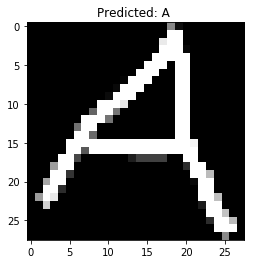

In [39]:
# Evaluate the four layer network with a single self written image
origin = cv2.imread("A.png", 0)
gray = convertByCV(origin)
#gray = cv2.resize(origin, (28,28))
im1 = gray.flatten('F') / 255.0

with tf.Session() as sess:
    saver.restore(sess, "./four_layer_model_with_relu_letter.ckpt") 
    X_new_scaled = fash_data.test.images[:20]
    X_new_scaled = [np.reshape(im1, (784))]
    #print(X_new_scaled[0])
    Z = y_conv.eval(feed_dict={X: X_new_scaled,keep_prob: 1.0})
    y_pred = np.argmax(Z, axis=1)


gen_image(im1, 
              "Predicted: %s " % (fash_labels[y_pred[0]+1])).show()

./data/own/letter
(110, 103)
squareGray(114, 114)
(28, 28)
(64, 78)
squareGray(82, 82)
(28, 28)
(52, 33)
squareGray(56, 56)
(28, 28)
(100, 43)
squareGray(104, 104)
(28, 28)
(38, 34)
squareGray(42, 42)
(28, 28)
(55, 58)
squareGray(62, 62)
(28, 28)
(69, 31)
squareGray(73, 73)
(28, 28)
(109, 67)
squareGray(113, 113)
(28, 28)
(42, 41)
squareGray(46, 46)
(28, 28)
(63, 46)
squareGray(67, 67)
(28, 28)
(56, 52)
squareGray(60, 60)
(28, 28)
(146, 72)
squareGray(150, 150)
(28, 28)
(61, 35)
squareGray(65, 65)
(28, 28)
(105, 59)
squareGray(109, 109)
(28, 28)
(62, 31)
squareGray(66, 66)
(28, 28)
(133, 74)
squareGray(137, 137)
(28, 28)
(83, 29)
squareGray(87, 87)
(28, 28)
(89, 47)
squareGray(93, 93)
(28, 28)
(64, 25)
squareGray(68, 68)
(28, 28)
(112, 65)
squareGray(116, 116)
(28, 28)
(79, 42)
squareGray(83, 83)
(28, 28)
(63, 22)
squareGray(67, 67)
(28, 28)
(106, 52)
squareGray(110, 110)
(28, 28)
(127, 60)
squareGray(131, 131)
(28, 28)
(75, 76)
squareGray(80, 80)
(28, 28)
(65, 72)
squareGray(76, 76)
(

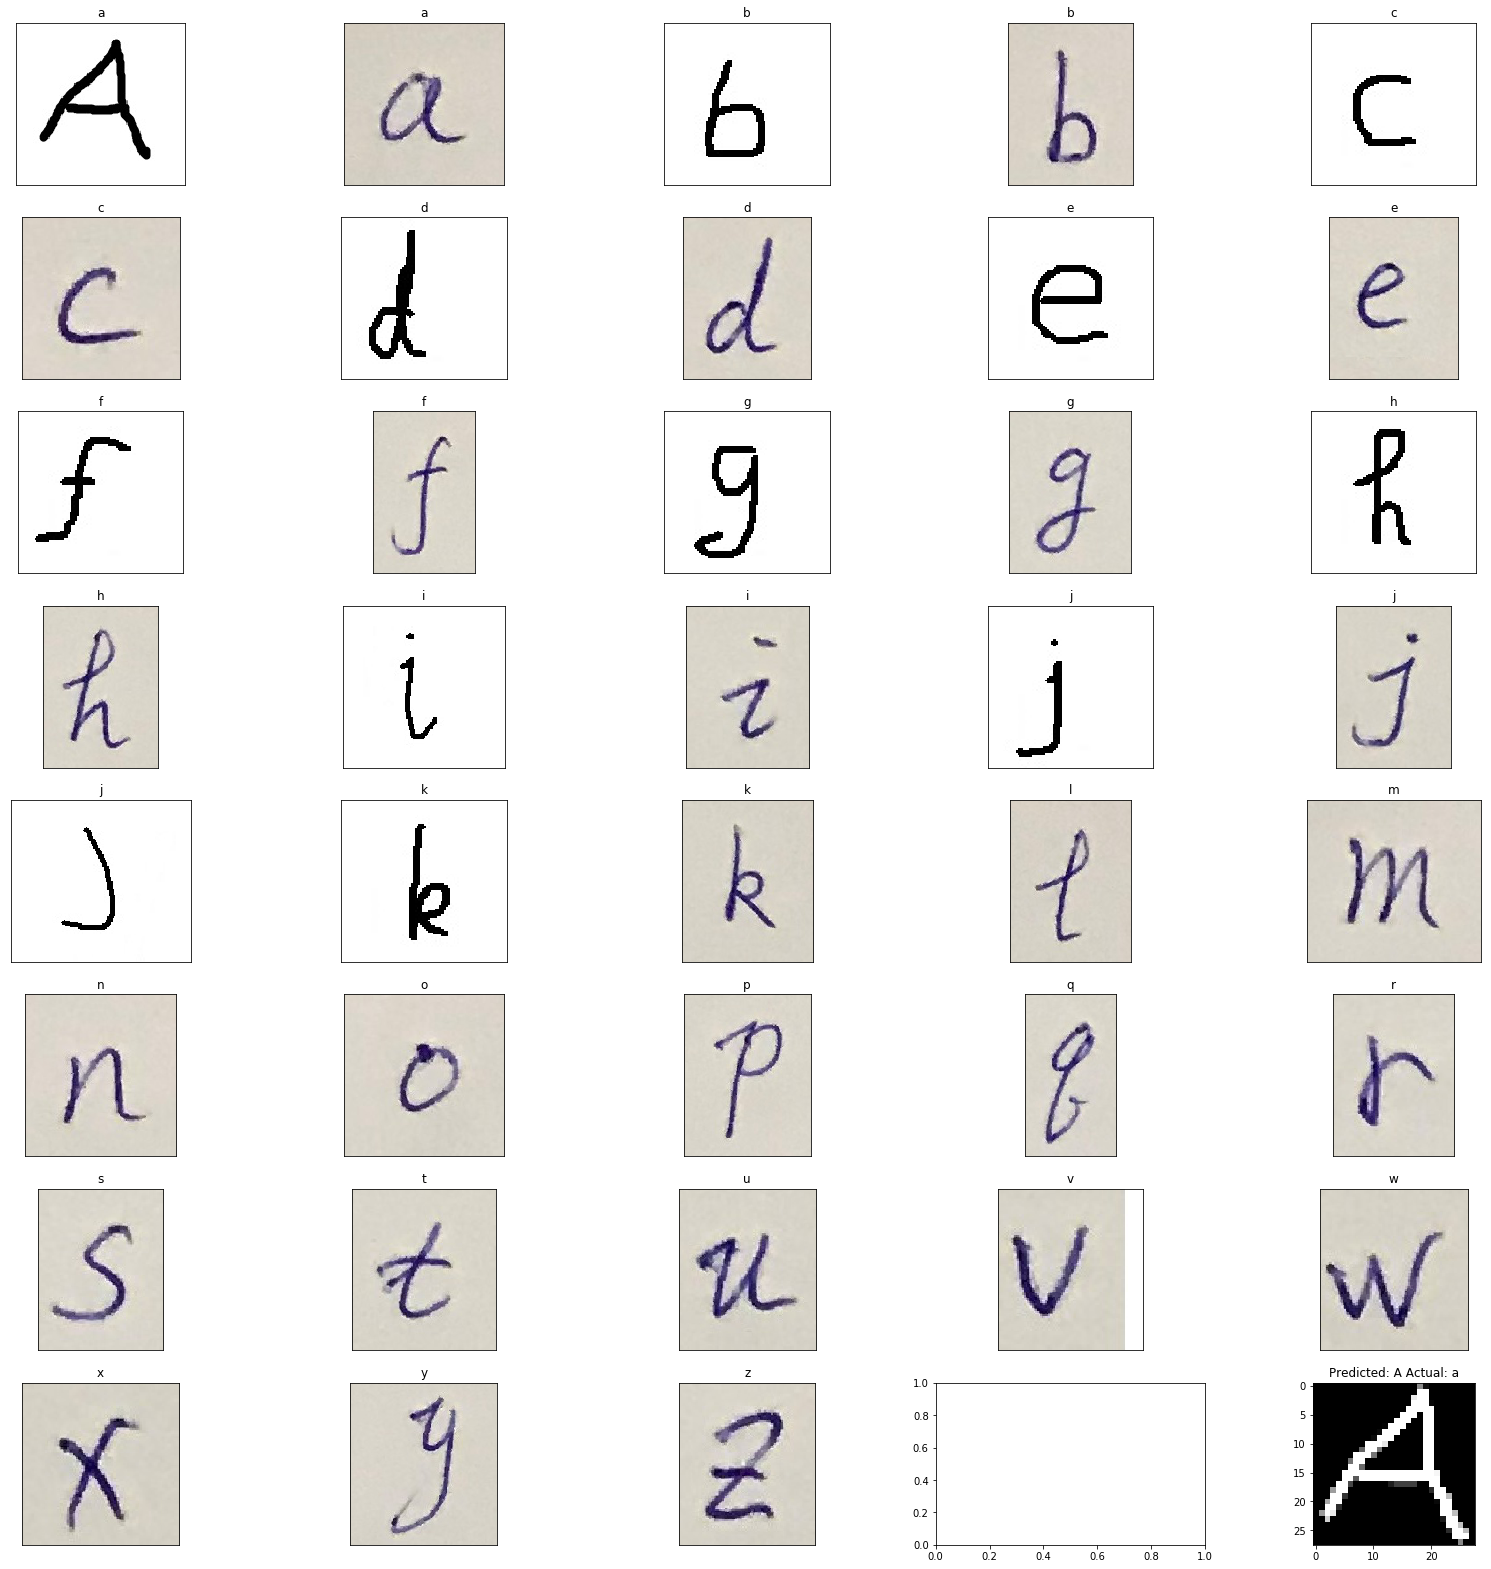

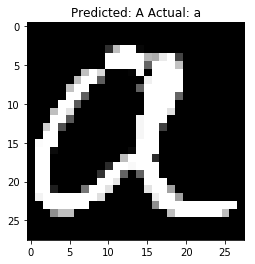

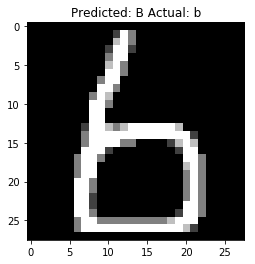

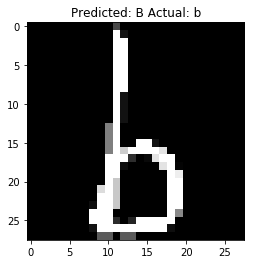

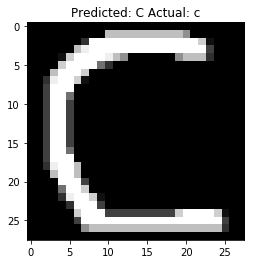

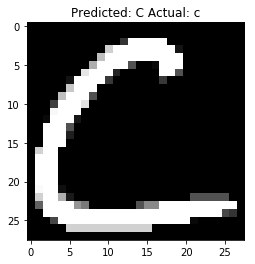

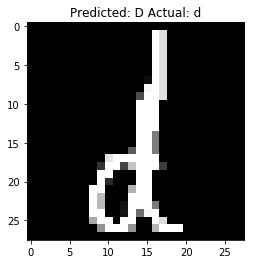

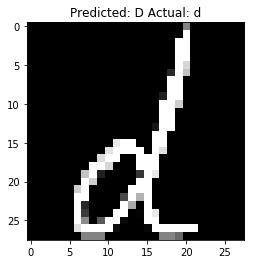

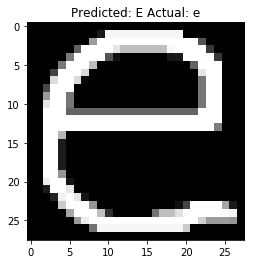

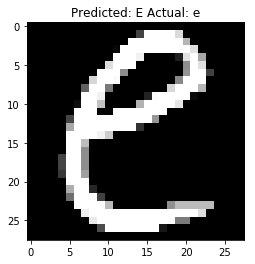

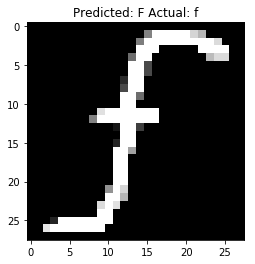

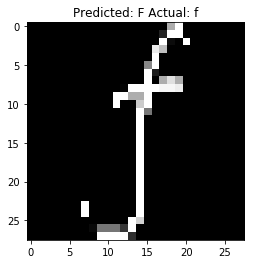

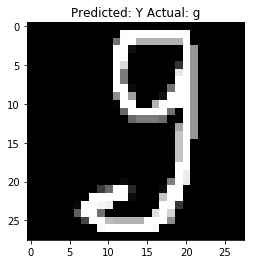

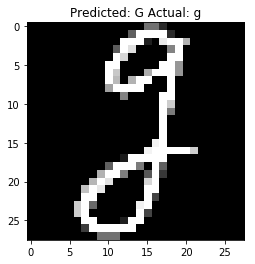

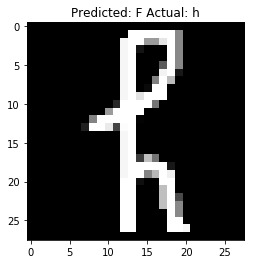

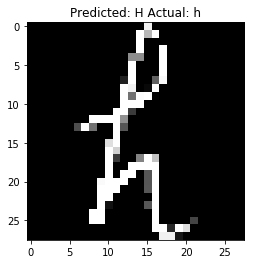

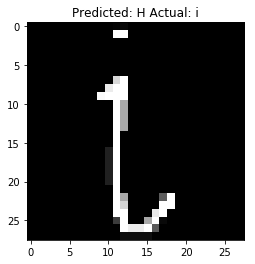

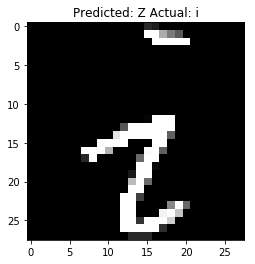

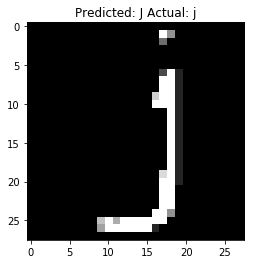

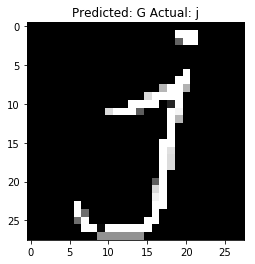

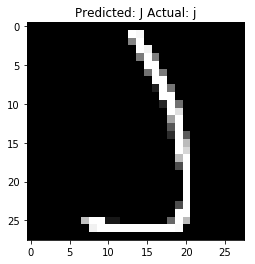

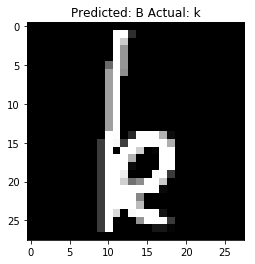

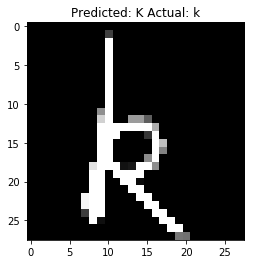

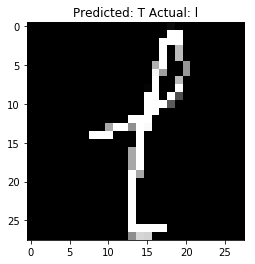

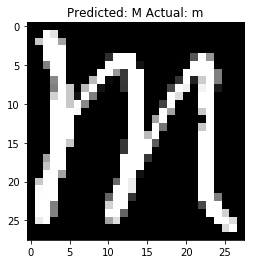

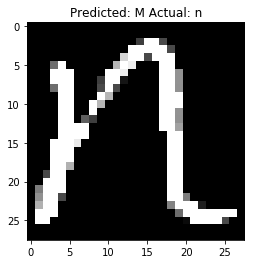

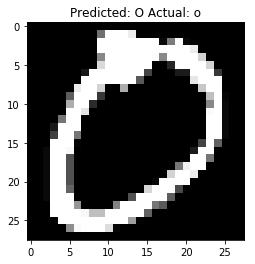

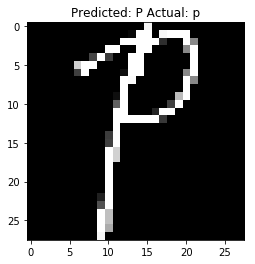

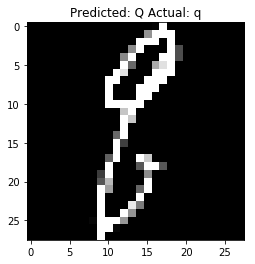

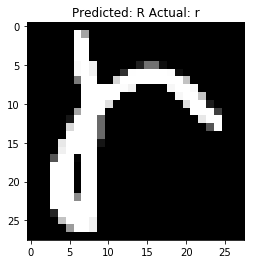

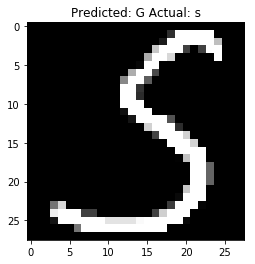

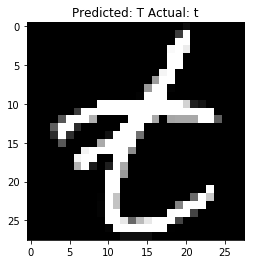

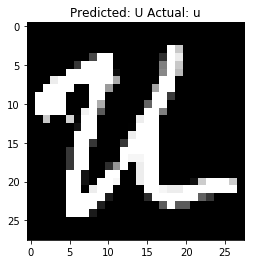

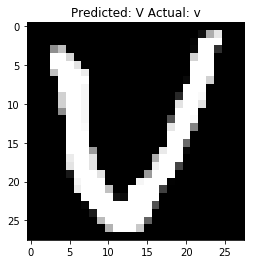

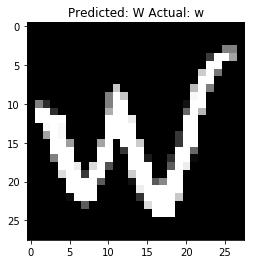

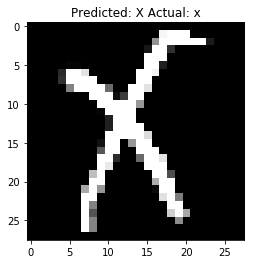

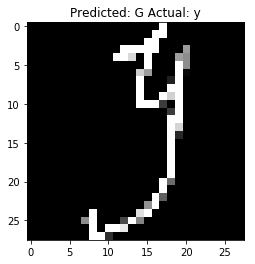

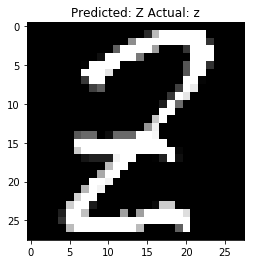

IndexError: index 38 is out of bounds for axis 0 with size 38

In [40]:
WORK_DIR = os.path.curdir
Image_DIR = WORK_DIR + '/data/own/letter'
num_images = 40
print(Image_DIR)
assert num_images % 5 == 0, "Please choose a number of images that divides by 4."

files = sorted(glob.glob(Image_DIR+'/*/*.jpg'))
#shuffle(files)
files = files[:num_images]
labels = [filename.split(os.sep)[-2] for filename in files]

fig, axs = plt.subplots((num_images // 5), 5, figsize=(28,28))
axs = axs.ravel()
count = 0
for file, label in zip(files, labels):
    img=mpimg.imread(file)
    axs[count].set_title(label)
    axs[count].imshow(img)
    axs[count].set_xticks([])
    axs[count].set_yticks([])
    count += 1 
n = 28 * 28
X_new_scaled = np.empty(shape=[0, 784])
Y_new_scaled = np.empty([0])

for file, label in zip(files, labels):
    origin = cv2.imread(file, 0)
    gray = convertByCV(origin)
    #gray = cv2.resize(gray, (28,28))
    im1 = gray.flatten('F') / 255.0
    
    im1 = np.reshape(im1, (1,784))
    X_new_scaled = np.append(X_new_scaled, im1, axis=0)
    
    
    Y_new_scaled = np.append(Y_new_scaled,[label])

with tf.Session() as sess:
    saver.restore(sess, "./four_layer_model_with_relu_letter.ckpt") 

    Z = y_conv.eval(feed_dict={X: X_new_scaled,keep_prob: 1.0})
    y_pred = np.argmax(Z, axis=1)

for im_index in range(num_images):
        #EMNIST letter dataset labels start from 1 to 26, 
        #the label argument for tf.nn.sparse_softmax_cross_entropy_with_logits is [0, number of classes)
        #so we need to decrease its labels by 1 to adjust labels value to [0,26)
        #and the predic output value is [0,26)
        #to map the predice output value to fash_label string that index from 1 to 26, we need to add 1 to predicue out value
        gen_image(X_new_scaled[im_index], 
              "Predicted: %s Actual: %s" % (fash_labels[y_pred[im_index]+1], 
                                           Y_new_scaled[im_index])).show()


### Graph Visualization
Let us visualize the graph we have just created using TensorBoard's API
Source code for TensorBoard visualization from: https://gist.github.com/j-min/b37a4c664b2496d284dad989c2c6fb6f

In [99]:
from IPython.display import clear_output, Image, display, HTML

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = b"<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))
    
# Show the graph as output below
show_graph(tf.get_default_graph())